In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [10]:
# Global variables

train_img_count = 175
test_img_count = 55

In [11]:
# TRAINING
train_young_adult_imgs = []
train_old_adult_imgs = []

# Load images
for i in range(1, train_img_count + 1):
    image_young = cv2.imread(f"train-young-adult/img-{i:03d}.png")
    image_old = cv2.imread(f"train-old-adult/img-{i:03d}.png")
    image_young = cv2.cvtColor(image_young, cv2.COLOR_BGR2LAB)
    image_old = cv2.cvtColor(image_old, cv2.COLOR_BGR2LAB)

    # vectorize
    image_young = image_young.flatten()
    image_old = image_old.flatten()
    
    train_young_adult_imgs.append(image_young)
    train_old_adult_imgs.append(image_old)

In [12]:
# Calculate means for training datasets
young_adult_means = np.mean(train_young_adult_imgs, axis=0)
old_adult_means = np.mean(train_old_adult_imgs, axis=0)

# Calculate variances for training datasets
young_adult_variances = np.var(train_young_adult_imgs, axis=0)
old_adult_variances = np.var(train_old_adult_imgs, axis=0)

In [13]:
# TESTING
test_young_adult_imgs = []
test_old_adult_imgs = []

# Load images
for i in range(1, test_img_count + 1):
    image_young = cv2.imread(f"test-young-adult/img-{i:02d}.png")
    image_old = cv2.imread(f"test-old-adult/img-{i:02d}.png")
    image_young = cv2.cvtColor(image_young, cv2.COLOR_BGR2LAB)
    image_old = cv2.cvtColor(image_old, cv2.COLOR_BGR2LAB)

    # vectorize
    image_young = image_young.flatten()
    image_old = image_old.flatten()

    test_young_adult_imgs.append(image_young)
    test_old_adult_imgs.append(image_old)

In [28]:
def calculate_log_probability(image, means, variances, sum_log_variances):
    """Calculates the logarithm of likelihood for an image based on the mean and variance."""
    diff = np.subtract(image, means)
    squared_diff = np.power(diff, 2)

    # To avoid warnings in console in case of errors
    with np.errstate(divide='ignore', invalid='ignore'):
        normalized_diff = np.where(variances != 0.0, squared_diff / (2 * variances), 0.0) # ((X - M)^2) / (2 * variance)

    probability = -0.5 * sum_log_variances - np.sum(normalized_diff) # -1/2 * Σ(lg(variance)) - Σ(((X - M)^2) / (2 * variance))

    return probability

In [29]:
# Calculate log variances
log_young_adult_variances = np.log(young_adult_variances[young_adult_variances != 0])
sum_log_young_adult_variances = np.sum(log_young_adult_variances)

log_old_adult_variances = np.log(old_adult_variances[old_adult_variances != 0])
sum_log_old_adult_variances = np.sum(log_old_adult_variances)

In [31]:
face_young_adult_detected_count = 0
for img in test_young_adult_imgs:
    Pr_x_given_y_1 = calculate_log_probability(img, young_adult_means, young_adult_variances, sum_log_young_adult_variances)
    Pr_x_given_y_0 = calculate_log_probability(img, old_adult_means, old_adult_variances, sum_log_old_adult_variances)

    if Pr_x_given_y_1 > Pr_x_given_y_0:
        face_young_adult_detected_count += 1

print('=== IMAGE TEST - LAB Color Space ===')
print(f"Face Young Adult detection accuracy: {(face_young_adult_detected_count / test_img_count * 100):03f}%")

face_old_adult_detected_count = 0
for img in test_old_adult_imgs:
    Pr_x_given_y_1 = calculate_log_probability(img, young_adult_means, young_adult_variances, sum_log_young_adult_variances)
    Pr_x_given_y_0 = calculate_log_probability(img, old_adult_means, old_adult_variances, sum_log_old_adult_variances)

    if Pr_x_given_y_1 < Pr_x_given_y_0:
        face_old_adult_detected_count += 1

print(f"Face Old Adult detection accuracy: {(face_old_adult_detected_count / test_img_count * 100):03f}%")

=== IMAGE TEST - LAB Color Space ===
Face Young Adult detection accuracy: 78.181818%
Face Old Adult detection accuracy: 94.545455%


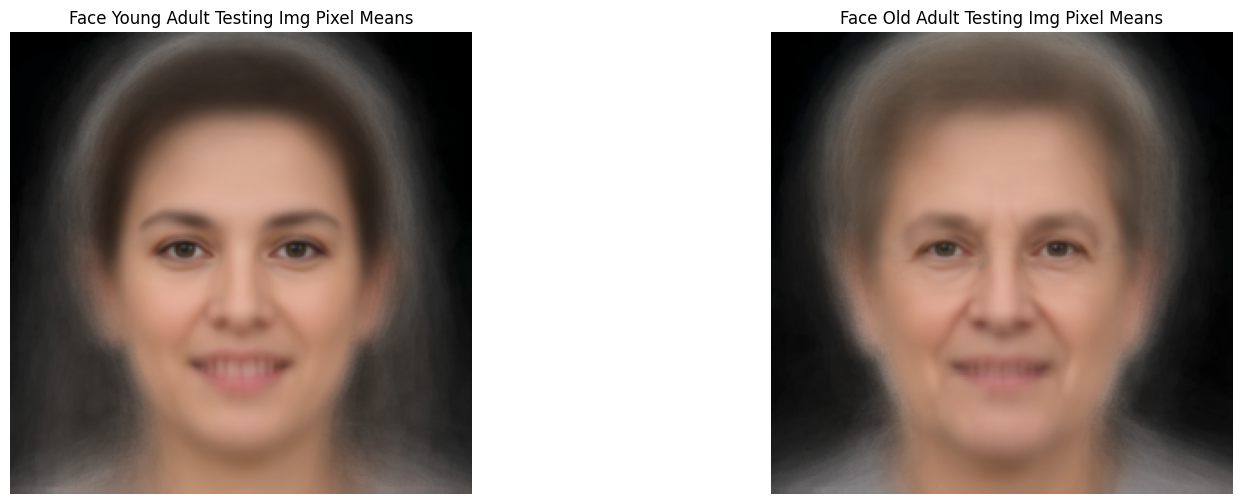

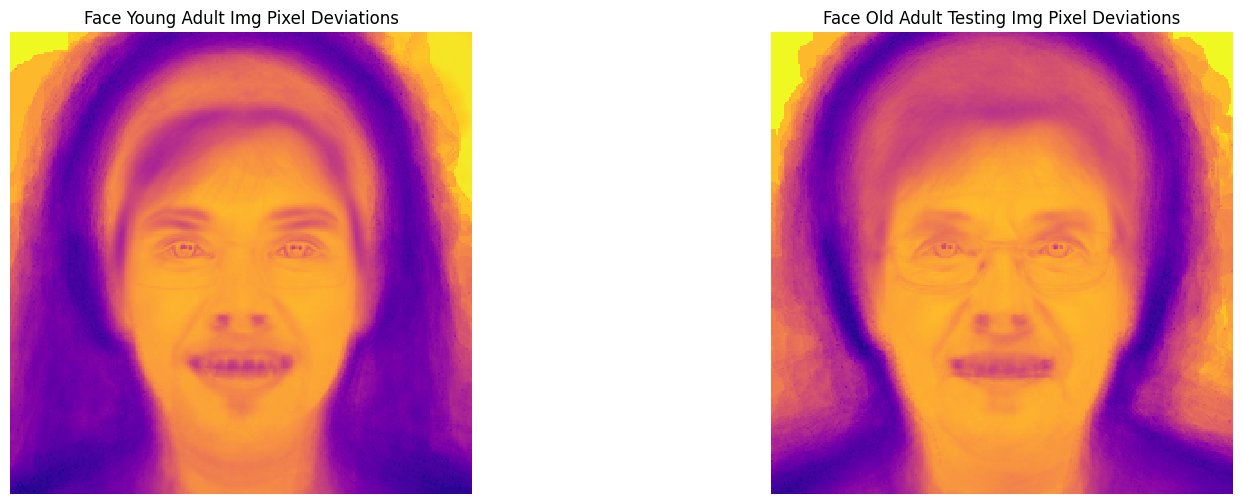

In [34]:
from matplotlib.colors import ListedColormap

def prepare_display_data(mean, variance, img_size=(256, 256)):
    """Prepares mean and deviation displays for visualization."""
    mean_display = mean.reshape(*img_size, 3)
    
    # Compute the deviation display
    dev_display = np.sqrt(variance).reshape(*img_size, 3).sum(axis=2)
    norm = np.linalg.norm(dev_display)
    dev_display = dev_display / norm if norm != 0 else dev_display

    return mean_display, dev_display

# Intermediate findings during training
young_adult_mean_display, young_adult_dev_display = prepare_display_data(young_adult_means, young_adult_variances)
old_adult_mean_display, old_adult_dev_display = prepare_display_data(old_adult_means, old_adult_variances)

# Custom colormap
reversed_cmap = ListedColormap(plt.cm.plasma.colors[::-1])

# Plot means
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(young_adult_mean_display.astype('uint8'), cv2.COLOR_LAB2RGB))
plt.title('Face Young Adult Testing Img Pixel Means')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(old_adult_mean_display.astype('uint8'), cv2.COLOR_LAB2RGB))
plt.title('Face Old Adult Testing Img Pixel Means')
plt.axis("off")

# Plot deviations
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(young_adult_dev_display, cmap=reversed_cmap, interpolation='nearest')
plt.title('Face Young Adult Img Pixel Deviations')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(old_adult_dev_display, cmap=reversed_cmap, interpolation='nearest')
plt.title('Face Old Adult Testing Img Pixel Deviations')
plt.axis("off")

plt.show()